In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
import cv2
from sklearn.covariance import EllipticEnvelope

# Processing evaluation

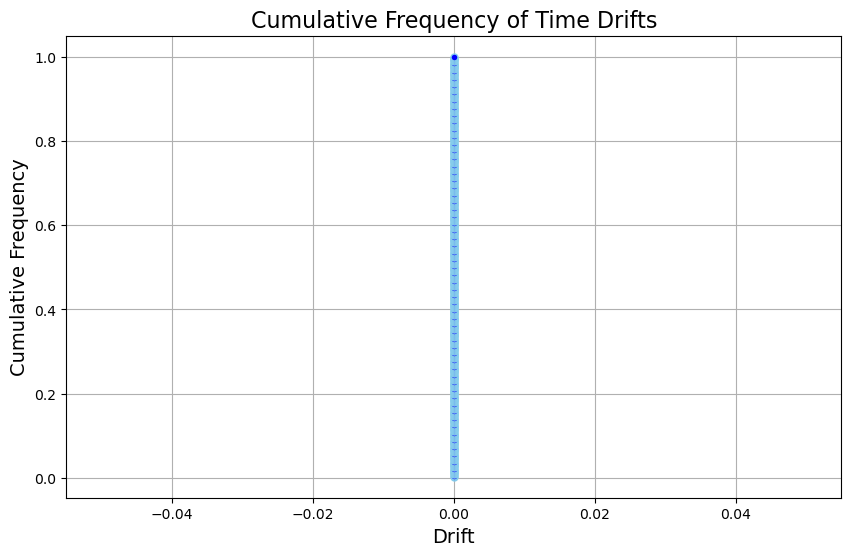

In [14]:
drifts = np.load("/calibration/data/hand_eye/processing/drifts.npy")
# Sort the data
drifts_sorted = np.sort(drifts)

# Calculate the cumulative distribution
cdf = np.arange(1, len(drifts_sorted) + 1) / len(drifts_sorted)

# Plotting the cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(drifts_sorted, cdf, marker='o', linestyle='-', color='skyblue', markerfacecolor='blue', markersize=5)

# Customizing the plot
plt.title('Cumulative Frequency of Time Drifts', fontsize=16)
plt.xlabel('Drift', fontsize=14)
plt.ylabel('Cumulative Frequency', fontsize=14)
plt.grid(True)

# Display the plot
plt.show()

In [15]:
hand2base_hs  = np.load("/calibration/data/hand_eye/processing/hand2base_hs.npy")  
target2eye_hs = np.load("/calibration/data/hand_eye/processing/target2eye_hs.npy")
frames        = np.load("/calibration/data/hand_eye/processing/frames.npy")

In [16]:
prev_frame  = frames[0]
prev_gray   = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
roi_centers = []

def find_chessboard_corners ( img, pattern_size=(9, 6)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, flags=cv2.CALIB_CB_FAST_CHECK)
    if ret:
        return ret, cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    else:
        return False, None

centers = []
for frame in frames[1:]:
    ret, corners = find_chessboard_corners(frame)
    corners_x = corners[:,0, 0]
    corners_y = corners[:,0, 1]
    center  = (int(np.mean(corners_x)),int(np.mean(corners_y)))
    centers.append(center)
    cv2.circle(frame, center, 2, (0, 255, 0), -1)
    cv2.imshow("frame", frame)
    cv2.waitKey(1)
cv2.destroyAllWindows()

In [17]:
good_hand2base_hs  = hand2base_hs
good_target2eye_hs = target2eye_hs 

In [18]:
target2eye_Rs = np.array([h[:3, :3] for h in good_target2eye_hs])
target2eye_ts = np.array([h[:3, 3] for h in good_target2eye_hs])
    
hand2base_Rs = np.array([h[:3, :3] for h in good_hand2base_hs])
hand2base_ts = np.array([h[:3, 3] for h in good_hand2base_hs])

R_eye2hand, t_eye2hand = cv2.calibrateHandEye(
            hand2base_Rs,
            hand2base_ts,
            target2eye_Rs,
            target2eye_ts,
            method = cv2.CALIB_HAND_EYE_TSAI
        )
print(R_eye2hand, t_eye2hand)

[[ 0.05088279  0.99863979 -0.01138052]
 [-0.99868002  0.05079823 -0.00759945]
 [-0.007011    0.01175218  0.99990636]] [[-0.00147664]
 [ 0.03809973]
 [ 0.11290021]]


In [19]:
eye2hand_hs = np.load("/calibration/data/hand_eye/processing/eye2hand_hs.npy")
for eye2hand_h in eye2hand_hs:
    r = eye2hand_h[:3, 3]
    print(r)

[-0.00147664  0.03809973  0.11290021]
[-0.00222842  0.03629652  0.11014856]
[-0.00221961  0.03629518  0.11009771]
[0.00092492 0.03503284 0.11138089]


In [20]:
target2base_hss = np.load("/calibration/data/hand_eye/reprojecting/target2base_hss.npy")
target2base_hss.shape
CALIB_HAND_EYE_METHODS = [
    "TSAI",
    "PARK",
    "HORAUD",
    "DANIILIDIS"
]


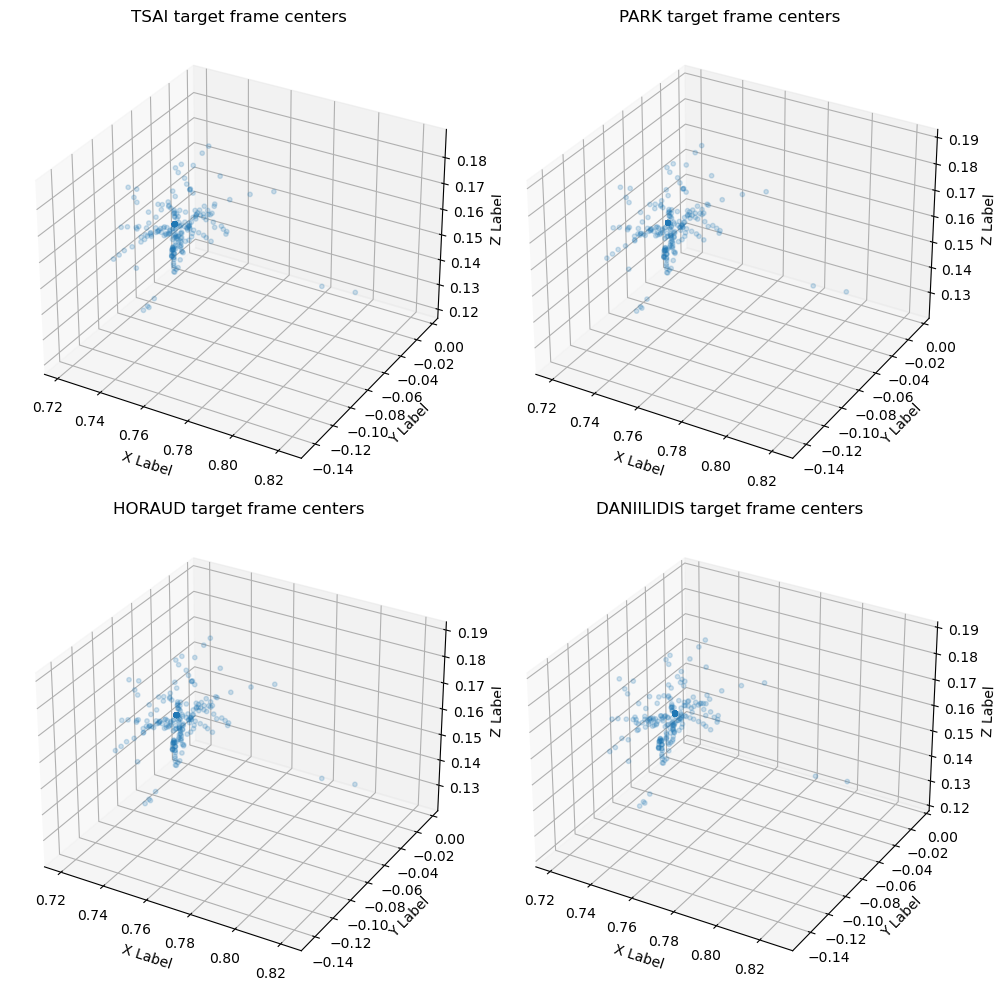

In [34]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(10, 10))

mses = []

for i in range(0, target2base_hss.shape[0], 1):

    r_idx = int(i / 2)
    c_idx = i % 2
    ax_centers = axs[r_idx, c_idx]
    
    points_3d  = target2base_hss[i, :, :3, 3:]
    points_3d  = points_3d.reshape((points_3d.shape[0], 3))
    
    ax_centers = axs[r_idx, c_idx]
    ax_centers.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10, marker='o',  alpha=0.2, zorder=-1)
    ax_centers.set_title(f"{CALIB_HAND_EYE_METHODS[i]} target frame centers")

    # Plot the points
    ax_centers.set_title(f"{CALIB_HAND_EYE_METHODS[i]} target frame centers")
    
    # Set labels
    ax_centers.set_xlabel('X Label')
    ax_centers.set_ylabel('Y Label')
    ax_centers.set_zlabel('Z Label')

    
# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

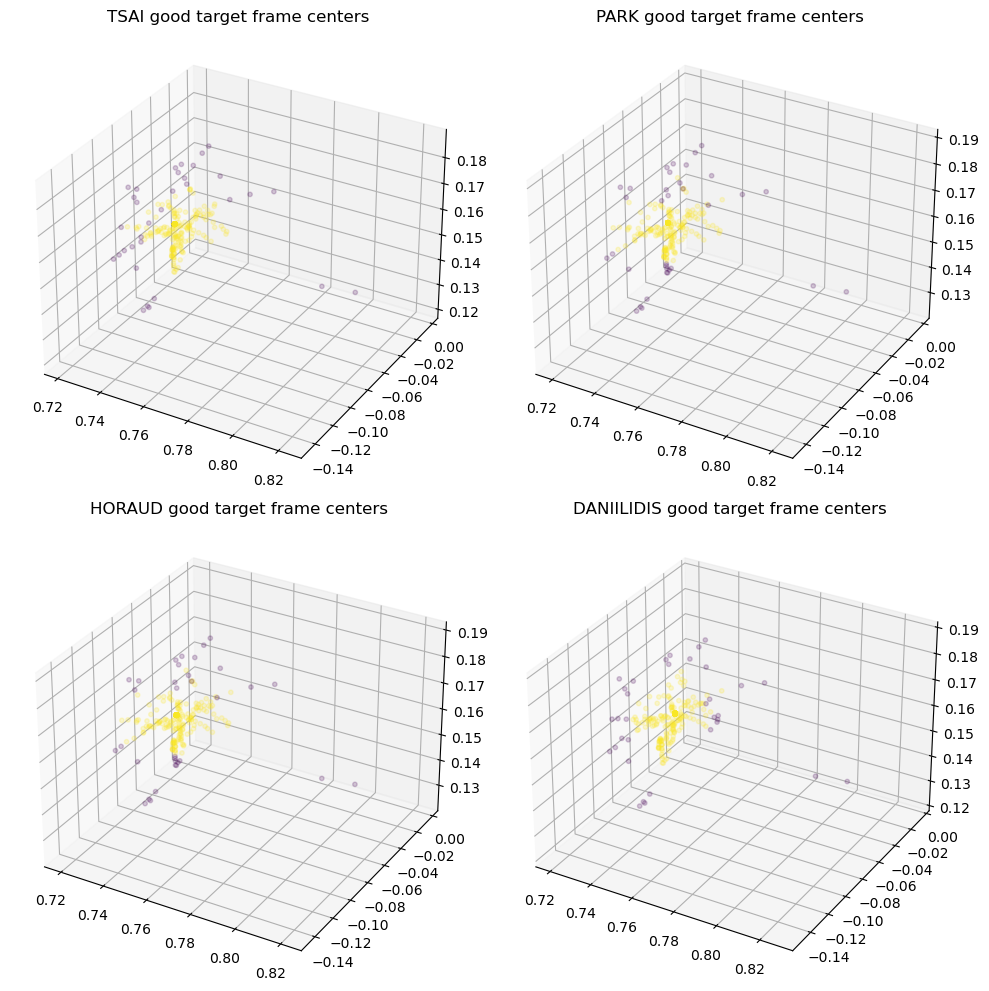

In [43]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(10, 10))

mses = []

for i in range(0, target2base_hss.shape[0], 1):
    r_idx = int(i / 2)
    c_idx = i % 2
    ax_inliers = axs[r_idx, c_idx]

    points_3d  = target2base_hss[i, :, :3, 3:]
    points_3d  = points_3d.reshape((points_3d.shape[0], 3))
    
    cov        = EllipticEnvelope(random_state = 42, contamination = 0.1)
    in_out     = cov.fit_predict(points_3d)
    inliers_c  = cov.location_

    ax_inliers.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10, marker='o', c=in_out,  alpha=0.2, zorder=-1)
    ax_inliers.set_title(f"{CALIB_HAND_EYE_METHODS[i]} good target frame centers")
    
    errs    = np.array([point - cov.location_ for (point, is_in) in zip(points_3d, in_out) if is_in > 0])
    mse     = np.mean(np.linalg.norm(errs))
    mses.append(mse)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

In [44]:
import math
print("Results")
print("=" * 10)
for i, mse in enumerate(mses):
    print(CALIB_HAND_EYE_METHODS[i] + ":", mse, "mm^2")
print("=" * 10)
best_idx = np.argmin(mses)
print("best:", CALIB_HAND_EYE_METHODS[best_idx], mses[best_idx])

Results
TSAI: 0.18807089601740248 mm^2
PARK: 0.21356190074530182 mm^2
HORAUD: 0.21433149433597048 mm^2
DANIILIDIS: 0.20064068114649203 mm^2
best: TSAI 0.18807089601740248


In [165]:

def compute_average_quaternion(rot_matrices):
    quaternions = np.array([t3d.quaternions.mat2quat(mat) for mat in rot_matrices])
    avg_quaternion = np.mean(quaternions, axis=0)
    avg_quaternion /= np.linalg.norm(avg_quaternion)  # Normalize to ensure it's a valid quaternion
    return avg_quaternion

def compute_rotation_errors_deg(real_quaternion, estimated_rotations):
    real_rot = t3d.quaternions.quat2mat(real_quaternion)
    n = estimated_rotations.shape[0]
    errors_deg = np.zeros(n)

    for i in range(n):
        est_quat = t3d.quaternions.mat2quat(estimated_rotations[i])
    
        # Compute the quaternion difference
        quat_diff = t3d.quaternions.qmult(t3d.quaternions.qinverse(real_quaternion), est_quat)

        # rot_diff, _ = cv2.Rodrigues(t3d.quaternions.quat2mat(quat_diff))
        
        # Compute the angle of rotation in radians
        angle_rad = 2 * np.arccos(np.clip(quat_diff[0], -1.0, 1.0))  # quat_diff[0] is the scalar part of the quaternion
        angle_deg = np.degrees(angle_rad)
        errors_deg[i] = angle_deg

    return np.meerrors_deg

In [166]:
errs = []

for i in range(0, target2base_hss.shape[0], 1):
    rots   = target2base_hss[i, :, :3, :3]
    center = compute_average_quaternion(rots)
    errors_deg = compute_rotation_errors_deg(center, rots)

AttributeError: module 'numpy' has no attribute 'meerrors_deg'

In [154]:
print("Results")
print("=" * 10)
for i, mse in enumerate(errs):
    print(CALIB_HAND_EYE_METHODS[i] + ":", mse, "mm^2")
print("=" * 10)
best_idx = np.argmin(errs)
print("best:", CALIB_HAND_EYE_METHODS[best_idx], mses[best_idx])

Results
TSAI: 23101.21874688206 mm^2
PARK: 26407.23131714836 mm^2
HORAUD: 27034.686432812607 mm^2
DANIILIDIS: 3717.968892128893 mm^2
best: DANIILIDIS 0.0027209103607580207


In [4]:
mses    = []
ptss    = []
centers = []

for i in range(1, 4):
    mse    = np.load(f"/calibration/data/hand_eye/processing/it_{i}/best_mse.npy")
    pts    = np.load(f"/calibration/data/hand_eye/processing/it_{i}/best_pts.npy")
    center = np.load(f"/calibration/data/hand_eye/processing/it_{i}/best_center.npy")

    mses.append(mse)
    ptss.append(pts)
    centers.append(center)

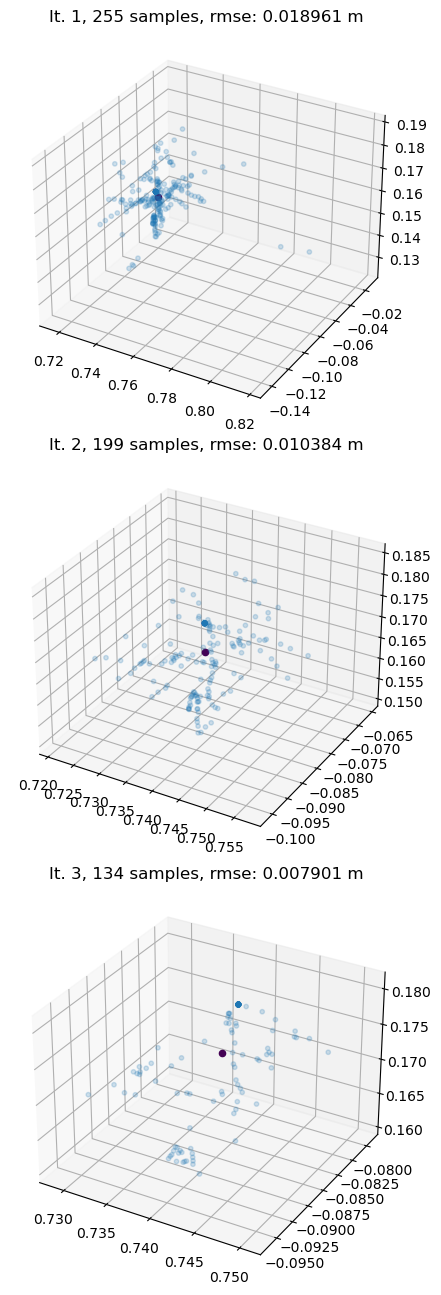

In [35]:
import math
fig, axs = plt.subplots(3, 1, subplot_kw={'projection': '3d'}, figsize=(13, 13))
mses     = [0.00035953428456303015, 0.00010782372452725206, 6.24219834231458E-5 ]
samples  = [255, 199, 134]
for i in range(0, 3):
    center     = centers[i]
    ax_inliers = axs[i]
    points_3d  = ptss[i]
    ax_inliers.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10, marker='o', alpha=0.2, zorder=-1)
    ax_inliers.scatter(center[0], center[1], center[2], marker = 'o', alpha=1, c=3, zorder=2)
    ax_inliers.set_title(f"It. {i + 1}, {samples[i]} samples, rmse: {round(math.sqrt(mses[i]), 6)} m")
# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

In [38]:
best_h = np.load("/calibration/data/hand_eye/processing/it_3/best_eye2hand_h.npy")
best_h

array([[ 0.03639109,  0.99933457,  0.00247026, -0.01135041],
       [-0.99923153,  0.03635109,  0.01466102,  0.03148736],
       [ 0.01456147, -0.00300189,  0.99988947,  0.10006773],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])